Problem Statement:

Scientists have determined that a known species of bird should be divided into 3 distinct and separate species. These species are endemic to a particular region of the country and their populations must be tracked and estimated with as much precision as possible. As such, a non-profit conservation society has taken up the task. They need to be able to log which species they have encountered based on the characteristics that their field officers observe in the wild. 

Using certain genetic traits and location data, can you predict the species of bird that has been observed?

This is a beginner-level practice competition and your goal is to predict the bird species (A, B, or C) based on attributes or location.

## Import libraries

In [107]:
import pandas as pd

# plotting
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
matplotlib.rcParams['figure.dpi'] = 100
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set(style="whitegrid")
%matplotlib inline

# ml
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, accuracy_score
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import ppscore as pps
from lazypredict.Supervised import LazyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier


## Load data

In [25]:
train = pd.read_csv("training_set.csv")
labels = pd.read_csv("training_target.csv")

# join target variable to training set
train = train.merge(labels, on="ID")

test = pd.read_csv("test_set.csv")

In [26]:
train.head()

,bill_depth,bill_length,wing_length,location,mass,sex,ID,species
0,14.30,48.20,210.00,loc_2,4600.00,0.00,284,C
1,14.40,48.40,203.00,loc_2,4625.00,0.00,101,C
2,18.40,NaN,200.00,loc_3,3400.00,0.00,400,B
3,14.98,47.50,NaN,NaN,4800.00,0.00,98,C
4,18.98,38.26,217.19,loc_3,5200.00,0.00,103,C


In [27]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 437 entries, 0 to 436
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   bill_depth   436 non-null    float64
 1   bill_length  296 non-null    float64
 2   wing_length  299 non-null    float64
 3   location     407 non-null    object 
 4   mass         435 non-null    float64
 5   sex          380 non-null    float64
 6   ID           437 non-null    int64  
 7   species      437 non-null    object 
dtypes: float64(5), int64(1), object(2)
memory usage: 30.7+ KB


In [28]:
train.isna().sum().sort_values(ascending = False)

bill_length    141
wing_length    138
sex             57
location        30
mass             2
bill_depth       1
ID               0
species          0
dtype: int64

In [29]:
train.shape

(437, 8)

In [30]:
train.shape[0]

437

In [31]:
train.isna().sum().sort_values(ascending = False).div(train.shape[0]).round(2)

bill_length   0.32
wing_length   0.32
sex           0.13
location      0.07
mass          0.00
bill_depth    0.00
ID            0.00
species       0.00
dtype: float64

In [32]:
for c in train.columns :
    print(f'Wartości kolumny {c}', '\n' * 2, train[c].sample(n = 10), '\n' )

Wartości kolumny bill_depth 

 161   17.60
312   18.98
415   17.20
318   16.80
270   16.10
185   19.60
110   20.50
227   17.50
43    19.80
56    18.00
Name: bill_depth, dtype: float64 

Wartości kolumny bill_length 

 362   38.79
215   48.83
254   44.12
78    50.50
281   38.79
82    47.50
208     NaN
4     38.26
298   38.26
246     NaN
Name: bill_length, dtype: float64 

Wartości kolumny wing_length 

 50       NaN
83    214.00
0     210.00
213   198.00
66    197.00
110   199.00
344      NaN
45       NaN
117   210.00
387   206.00
Name: wing_length, dtype: float64 

Wartości kolumny location 

 309    loc_1
397    loc_3
53     loc_2
411    loc_1
69     loc_3
111    loc_2
210    loc_3
270    loc_2
322    loc_2
138    loc_1
Name: location, dtype: object 

Wartości kolumny mass 

 219   4450.00
45    4700.00
374   5150.00
111   5700.00
157   4200.00
120   3550.00
367   5400.00
340   5550.00
137   4875.00
243   5000.00
Name: mass, dtype: float64 

Wartości kolumny sex 

 111   1.00
177   1.

In [33]:
train[ train.duplicated() ]

,bill_depth,bill_length,wing_length,location,mass,sex,ID,species
434,16.60,55.51,187.00,loc_2,2900.00,NaN,47,B
436,18.90,NaN,NaN,loc_3,4300.00,1.00,92,A


In [34]:
train.duplicated().sum()

2

In [35]:
print("Przed usunięciem duplikatów mamy {} wierszy".format(train.shape[0]))

Przed usunięciem duplikatów mamy 437 wierszy


In [36]:
train = train[ ~ train.duplicated() ]

In [37]:
print("Po usunięciu duplikatów mamy {} wierszy".format(train.shape[0]))

Po usunięciu duplikatów mamy 435 wierszy


In [38]:
statystyki = train.describe().round(2)
statystyki.head(2)

,bill_depth,bill_length,wing_length,mass,sex,ID
count,434.00,295.00,298.00,433.00,379.00,435.00
mean,17.30,46.17,202.76,4290.88,0.51,273.77


In [39]:
statystyki.loc[ ['mean', '50%', 'min', 'max'], 'bill_depth' : 'sex'  ]

,bill_depth,bill_length,wing_length,mass,sex
mean,17.30,46.17,202.76,4290.88,0.51
50%,17.60,47.50,199.00,4200.00,1.00
min,13.10,38.26,172.00,2700.00,0.00
max,21.50,59.60,231.00,6300.00,1.00


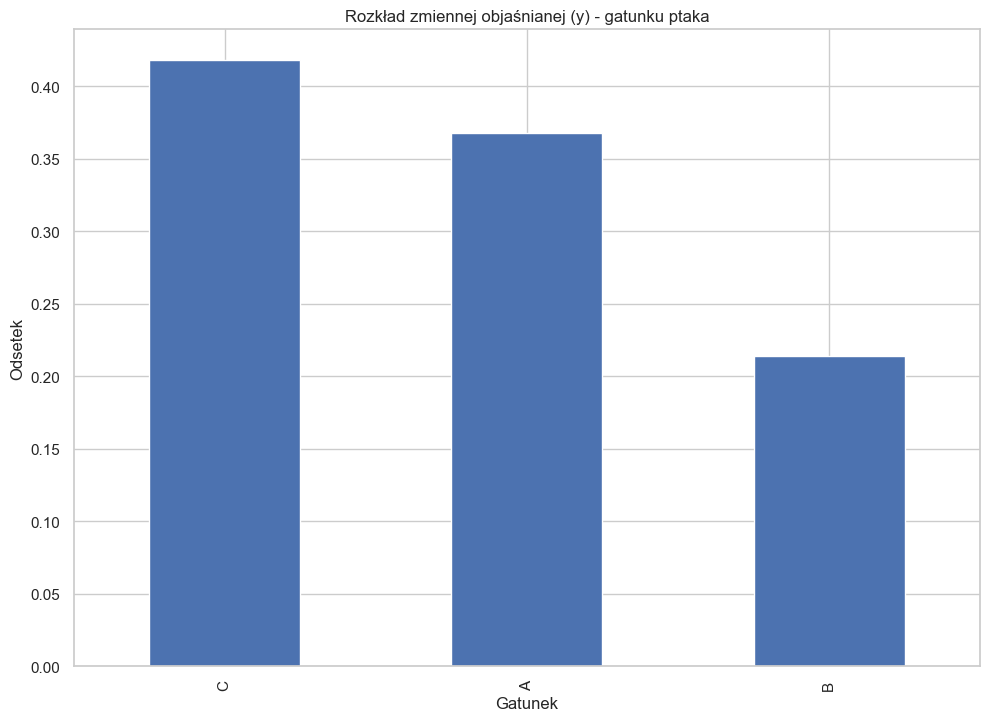

In [40]:
train.species.value_counts(normalize = True, dropna = False).plot.bar()
plt.title('Rozkład zmiennej objaśnianej (y) - gatunku ptaka')
plt.ylabel('Odsetek')
plt.xlabel('Gatunek')
plt.show()

In [41]:
train.location.unique()

array(['loc_2', 'loc_3', nan, 'loc_1'], dtype=object)

In [42]:
train.head(2)

,bill_depth,bill_length,wing_length,location,mass,sex,ID,species
0,14.30,48.20,210.00,loc_2,4600.00,0.00,284,C
1,14.40,48.40,203.00,loc_2,4625.00,0.00,101,C


In [43]:
train.ID.nunique() == train.shape[0]

True

In [44]:
train = train.set_index('ID')
train.head(2)

,bill_depth,bill_length,wing_length,location,mass,sex,species
ID,,,,,,,
284,14.30,48.20,210.00,loc_2,4600.00,0.00,C
101,14.40,48.40,203.00,loc_2,4625.00,0.00,C


In [45]:
435*0.7

304.5

In [46]:
y = train['species']
X = train.drop('species', axis = 1)


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

X_train.head()

,bill_depth,bill_length,wing_length,location,mass,sex
ID,,,,,,
185,14.98,47.50,NaN,loc_1,4200.00,0.00
503,15.80,45.20,215.00,loc_2,5300.00,1.00
430,14.20,42.80,209.00,loc_2,4700.00,0.00
355,18.98,38.26,NaN,loc_3,4875.00,NaN
125,15.60,46.40,221.00,loc_2,5000.00,1.00


In [47]:
X_train.isna().sum().sort_values(ascending = False).div(X_train.shape[0]).round(2)

bill_length   0.30
wing_length   0.29
sex           0.12
location      0.06
bill_depth    0.00
mass          0.00
dtype: float64

In [48]:
trainset = pd.concat( [ X_train, y_train ], axis = 1 )
testset = pd.concat( [ X_test, y_test ], axis = 1 )

In [49]:
trainset.head()

,bill_depth,bill_length,wing_length,location,mass,sex,species
ID,,,,,,,
185,14.98,47.50,NaN,loc_1,4200.00,0.00,C
503,15.80,45.20,215.00,loc_2,5300.00,1.00,C
430,14.20,42.80,209.00,loc_2,4700.00,0.00,C
355,18.98,38.26,NaN,loc_3,4875.00,NaN,C
125,15.60,46.40,221.00,loc_2,5000.00,1.00,C


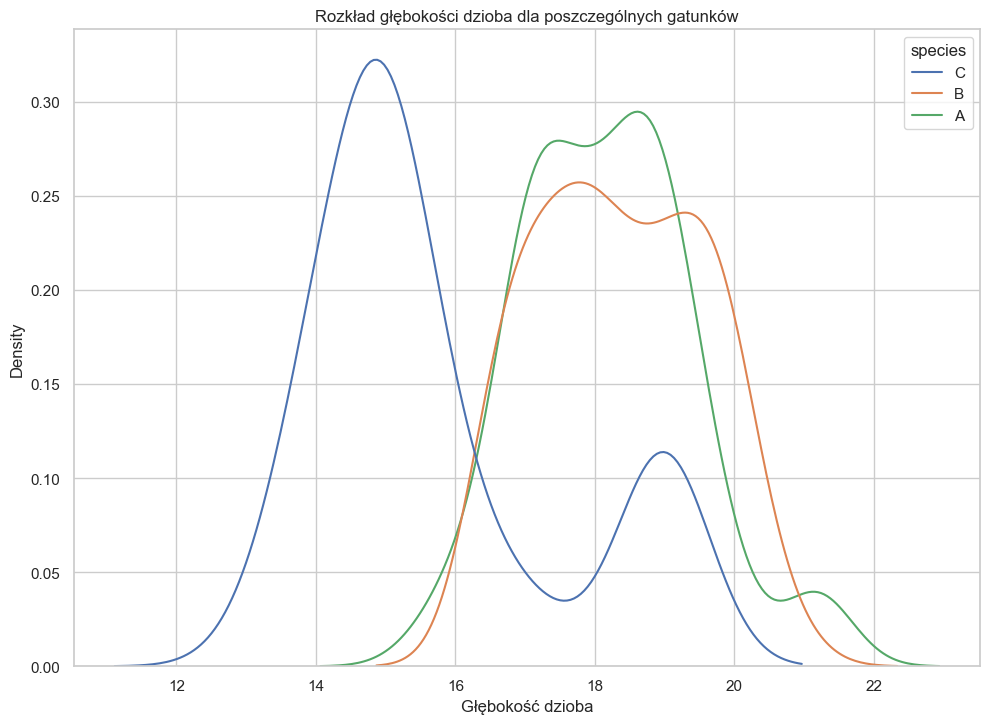

In [50]:
sns.kdeplot(x = 'bill_depth', data = trainset, hue = 'species', common_norm = False)
plt.title('Rozkład głębokości dzioba dla poszczególnych gatunków')
plt.xlabel('Głębokość dzioba')
plt.show()

In [51]:
trainset['bill_length'].isna()

ID
185    False
503    False
430    False
355    False
125    False
       ...  
155     True
277     True
211    False
18      True
316    False
Name: bill_length, Length: 304, dtype: bool

In [52]:
bill_length_jest = trainset [ ~ trainset['bill_length'].isna() ]
bill_length_jest.head()

,bill_depth,bill_length,wing_length,location,mass,sex,species
ID,,,,,,,
185,14.98,47.50,NaN,loc_1,4200.00,0.00,C
503,15.80,45.20,215.00,loc_2,5300.00,1.00,C
430,14.20,42.80,209.00,loc_2,4700.00,0.00,C
355,18.98,38.26,NaN,loc_3,4875.00,NaN,C
125,15.60,46.40,221.00,loc_2,5000.00,1.00,C


In [53]:
bill_length_nie_ma = trainset [ trainset['bill_length'].isna() ]
bill_length_nie_ma.head()

,bill_depth,bill_length,wing_length,location,mass,sex,species
ID,,,,,,,
296,16.80,NaN,NaN,loc_1,3700.00,0.00,A
304,17.10,NaN,191.00,loc_1,3050.00,0.00,A
497,18.60,NaN,189.00,loc_1,3325.00,1.00,A
351,15.50,NaN,188.00,loc_3,3050.00,0.00,A
522,17.40,NaN,NaN,loc_1,3800.00,0.00,A


In [54]:
trainset[ 'bill_length_nan'  ] = trainset['bill_length'].isna().astype(int)
trainset.head(3)

,bill_depth,bill_length,wing_length,location,mass,sex,species,bill_length_nan
ID,,,,,,,,
185,14.98,47.50,NaN,loc_1,4200.00,0.00,C,0
503,15.80,45.20,215.00,loc_2,5300.00,1.00,C,0
430,14.20,42.80,209.00,loc_2,4700.00,0.00,C,0


In [55]:
testset[ 'bill_length_nan'  ] = testset['bill_length'].isna().astype(int)


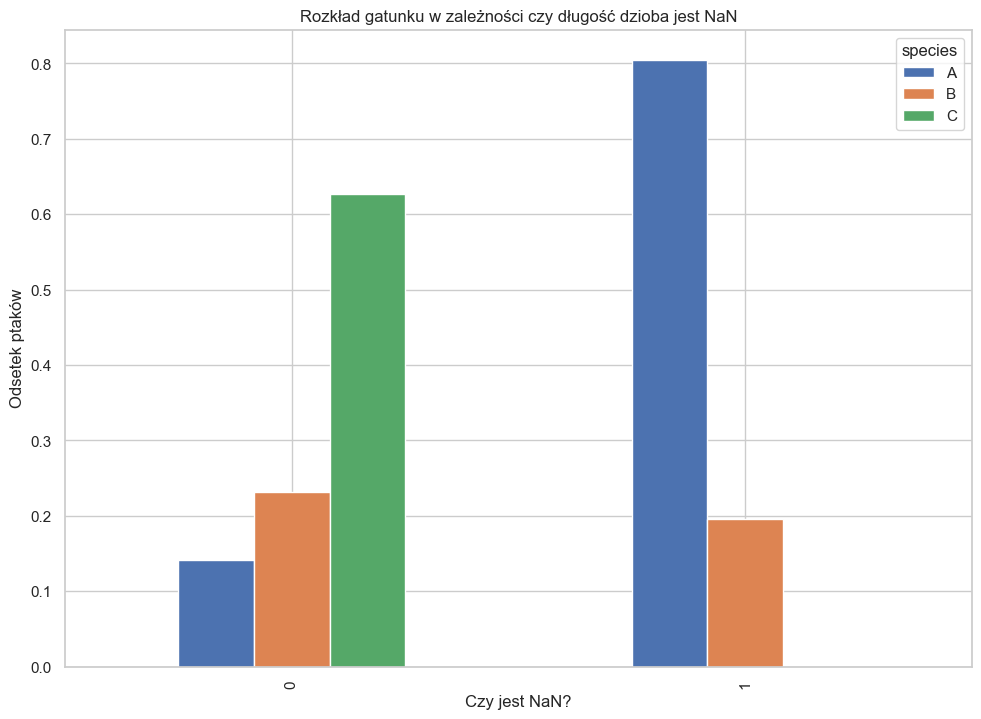

In [56]:
trainset.groupby('bill_length_nan')['species'].value_counts(normalize = True).unstack().plot.bar()
plt.title('Rozkład gatunku w zależności czy długość dzioba jest NaN')
plt.xlabel('Czy jest NaN?')
plt.ylabel('Odsetek ptaków')
plt.show()

In [57]:
encoder = SimpleImputer() # domyslnie uzywa sredniej
cols_avg = ['bill_length', 'wing_length']
trainset[cols_avg] = encoder.fit_transform(trainset[cols_avg])

In [58]:
testset[cols_avg] = encoder.transform(testset[cols_avg])

In [59]:
trainset.isna().sum().sort_values(ascending = False)

sex                37
location           19
bill_depth          0
bill_length         0
wing_length         0
mass                0
species             0
bill_length_nan     0
dtype: int64

In [60]:
trainset.shape

(304, 8)

In [61]:
one_hot = OneHotEncoder(sparse = False)
trainset['location'] = one_hot.fit_transform(pd.DataFrame(trainset['location']).values.reshape(-1, 1))
testset['location'] = one_hot.transform(pd.DataFrame(testset['location']).values.reshape(-1, 1))

In [62]:
trainset.shape

(304, 8)

In [63]:
trainset.head(2)

,bill_depth,bill_length,wing_length,location,mass,sex,species,bill_length_nan
ID,,,,,,,,
185,14.98,47.50,202.81,1.00,4200.00,0.00,C,0
503,15.80,45.20,215.00,0.00,5300.00,1.00,C,0


In [64]:
trainset.isna().sum().sort_values(ascending = False) # zniknely braki po zastosowaniu OHE

sex                37
bill_depth          0
bill_length         0
wing_length         0
location            0
mass                0
species             0
bill_length_nan     0
dtype: int64

In [65]:
trainset.location.unique() # gdzie trzecia lokacja?

array([1., 0.])

In [66]:
ohe_test = OneHotEncoder(sparse = False)
ohe_test.fit_transform( np.array( ['a', 'b', 'c'] ).reshape(-1, 1) )

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [67]:
encoder = SimpleImputer(strategy = 'most_frequent')
cols_mode = ['sex']
trainset[cols_mode] = encoder.fit_transform(trainset[cols_mode])

In [68]:
testset[cols_mode] = encoder.transform(testset[cols_mode])

In [69]:
trainset.isna().sum().sum()

0

In [70]:
trainset['location'].head()

ID
185   1.00
503   0.00
430   0.00
355   0.00
125   0.00
Name: location, dtype: float64

In [71]:
trainset.head(2)

,bill_depth,bill_length,wing_length,location,mass,sex,species,bill_length_nan
ID,,,,,,,,
185,14.98,47.50,202.81,1.00,4200.00,0.00,C,0
503,15.80,45.20,215.00,0.00,5300.00,1.00,C,0


In [72]:
x = 3
y = 5

print(x, y)

x, y = 7, 8

print(x, y)

3 5
7 8


In [73]:
X_train, y_train = trainset.drop('species', axis = 1), trainset['species']
X_test, y_test = testset.drop('species', axis = 1), testset['species']

In [74]:
X_test.isna().sum()

bill_depth         1
bill_length        0
wing_length        0
location           0
mass               2
sex                0
bill_length_nan    0
dtype: int64

In [75]:
X_test['bill_depth'] = X_test['bill_depth'].fillna(X_test['bill_depth'].mean())

In [76]:
X_train.head()

,bill_depth,bill_length,wing_length,location,mass,sex,bill_length_nan
ID,,,,,,,
185,14.98,47.50,202.81,1.00,4200.00,0.00,0
503,15.80,45.20,215.00,0.00,5300.00,1.00,0
430,14.20,42.80,209.00,0.00,4700.00,0.00,0
355,18.98,38.26,202.81,0.00,4875.00,0.00,0
125,15.60,46.40,221.00,0.00,5000.00,1.00,0


In [77]:
pps.predictors(trainset, y = 'species')

,x,y,ppscore,case,is_valid_score,metric,baseline_score,model_score,model
0,bill_length,species,0.72,classification,True,weighted F1,0.36,0.82,DecisionTreeClassifier()
1,bill_depth,species,0.58,classification,True,weighted F1,0.36,0.73,DecisionTreeClassifier()
2,mass,species,0.54,classification,True,weighted F1,0.36,0.71,DecisionTreeClassifier()
3,wing_length,species,0.47,classification,True,weighted F1,0.36,0.66,DecisionTreeClassifier()
4,bill_length_nan,species,0.37,classification,True,weighted F1,0.36,0.60,DecisionTreeClassifier()
5,location,species,0.08,classification,True,weighted F1,0.36,0.42,DecisionTreeClassifier()
6,sex,species,0.00,classification,True,weighted F1,0.36,0.27,DecisionTreeClassifier()


In [106]:
pps.matrix(trainset)

,x,y,ppscore,case,is_valid_score,metric,baseline_score,model_score,model
0,bill_depth,bill_depth,1.00,predict_itself,True,None,0.00,1.00,None
1,bill_depth,bill_length,0.00,regression,True,mean absolute error,2.86,3.34,DecisionTreeRegressor()
2,bill_depth,wing_length,0.14,regression,True,mean absolute error,8.53,7.35,DecisionTreeRegressor()
3,bill_depth,location,0.00,regression,True,mean absolute error,0.17,0.26,DecisionTreeRegressor()
4,bill_depth,mass,0.36,regression,True,mean absolute error,677.30,430.76,DecisionTreeRegressor()
...,...,...,...,...,...,...,...,...,...
59,bill_length_nan,location,0.00,regression,True,mean absolute error,0.17,0.28,DecisionTreeRegressor()
60,bill_length_nan,mass,0.17,regression,True,mean absolute error,677.30,561.34,DecisionTreeRegressor()
61,bill_length_nan,sex,0.00,regression,True,mean absolute error,0.42,0.49,DecisionTreeRegressor()
62,bill_length_nan,species,0.37,classification,True,weighted F1,0.36,0.60,DecisionTreeClassifier()


dt = DecisionTreeClassifier()
dt.fit(bill_length, y)

dt = DecisionTreeClassifier()
dt.fit(bill_depth, y)

In [78]:
X_test['mass'] = X_test['mass'].fillna(X_test['mass'].mean())

In [79]:
X_train.columns

Index(['bill_depth', 'bill_length', 'wing_length', 'location', 'mass', 'sex',
       'bill_length_nan'],
      dtype='object')

In [80]:
X_test.isna().sum()

bill_depth         0
bill_length        0
wing_length        0
location           0
mass               0
sex                0
bill_length_nan    0
dtype: int64

PPS = (F1_model - F1_naive) / (1 - F1_naive)

In [118]:
boost = GradientBoostingClassifier(learning_rate = 0.05)
boost.fit(X_train, y_train)
train_predictions = boost.predict(X_train)
predictions = boost.predict(X_test)


In [119]:
train_acc = accuracy_score(y_train, train_predictions)
test_acc = accuracy_score(y_test, predictions)

print( "Accuracy na zbiorze treningowym wynosi {} a na testowym {}".format(train_acc, test_acc))

Accuracy na zbiorze treningowym wynosi 1.0 a na testowym 0.9312977099236641


In [126]:
from datetime import datetime
# Get current date and time
now = datetime.now()
# Format using strftime
formatted_date = now.strftime('%Y-%m-%d %H-%M-%S')
print(formatted_date) # Output: 2023-03-10 15:45:30

2026-02-01 10-20-47


In [132]:
X_train.head(2).to_csv('sample_rows_to_predict.csv')

In [129]:
pd.Series( X_train.columns.tolist() ).to_csv('kolumny oczekiwane przez gradient_boost_created_{}'.format(formatted_date))

In [131]:
import joblib



joblib.dump(boost, 'gradient_boost_created_{}.joblib'.format(formatted_date))

['gradient_boost_created_2026-02-01 10-20-47.joblib']

In [83]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()



y_train = pd.Series(
    le.fit_transform(y_train),
    index=y_train.index
)

y_test = pd.Series(
    le.transform(y_test),
    index=y_test.index
)

le.classes_

array(['A', 'B', 'C'], dtype=object)

In [84]:
y_train.head()

ID
185    2
503    2
430    2
355    2
125    2
dtype: int32

In [393]:
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train, X_test, y_train, y_test)
models

100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 40.35it/s]

[02:23:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000051 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 200
[LightGBM] [Info] Number of data points in the train set: 304, number of used features: 7
[LightGBM] [Info] Start training from score -1.072637
[LightGBM] [Info] Start training from score -1.512335
[LightGBM] [Info] Start training from score -0.826679
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warni

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
RandomForestClassifier,0.97,0.98,None,0.97,0.11
ExtraTreesClassifier,0.97,0.97,None,0.97,0.09
LGBMClassifier,0.95,0.96,None,0.96,0.07
LogisticRegression,0.96,0.96,None,0.96,0.00
CalibratedClassifierCV,0.96,0.96,None,0.96,0.05
SVC,0.96,0.95,None,0.96,0.01
NuSVC,0.96,0.95,None,0.96,0.01
XGBClassifier,0.94,0.95,None,0.94,0.11
SGDClassifier,0.95,0.95,None,0.95,0.01


## Znajdowanie parametrów modelu w kroskwalidacji

In [88]:
kwadraty_liczb = { i : i ** 2 for i in range(4) }
kwadraty_liczb

{0: 0, 1: 1, 2: 4, 3: 9}

In [120]:
param_distributions = {'min_samples_leaf' : [10, 15, 20 ], 
                       'min_samples_split' : [10, 15, 20 ], 
                       'max_depth' : [1, 2, 3, 4  ] }



grid = RandomizedSearchCV(boost, param_distributions, n_iter = 30)
grid.fit(X_train, y_train)

RandomizedSearchCV(estimator=GradientBoostingClassifier(learning_rate=0.05),
                   n_iter=30,
                   param_distributions={'max_depth': [1, 2, 3, 4],
                                        'min_samples_leaf': [10, 15, 20],
                                        'min_samples_split': [10, 15, 20]})

In [121]:
grid.best_estimator_

GradientBoostingClassifier(learning_rate=0.05, max_depth=4, min_samples_leaf=20,
                           min_samples_split=15)

In [100]:
#grid.cv_results_ 

In [122]:
cv_acc = round ( grid.best_score_ , 3)

In [123]:
nowy_model = grid.best_estimator_
new_train_preds = nowy_model.predict(X_train)
new_preds = nowy_model.predict(X_test)


new_train_acc = round ( accuracy_score(y_train, new_train_preds), 4 )
new_test_acc = round(  accuracy_score(y_test, new_preds), 4 )

print( "Accuracy na zbiorze treningowym wynosi {} a na testowym {}. Accuracy w kroswalidacji {}".format(new_train_acc, new_test_acc, cv_acc))

Accuracy na zbiorze treningowym wynosi 0.9868 a na testowym 0.9237. Accuracy w kroswalidacji 0.928


In [105]:
print(classification_report(y_test, new_preds))

              precision    recall  f1-score   support

           0       0.98      0.93      0.95        56
           1       0.89      0.96      0.93        26
           2       0.96      0.98      0.97        49

    accuracy                           0.95       131
   macro avg       0.94      0.96      0.95       131
weighted avg       0.96      0.95      0.95       131



In [91]:
#help(forest)

In [87]:
#help(LazyClassifier)
help(RandomizedSearchCV)

Help on class RandomizedSearchCV in module sklearn.model_selection._search:

class RandomizedSearchCV(BaseSearchCV)
 |  RandomizedSearchCV(estimator, param_distributions, *, n_iter=10, scoring=None, n_jobs=None, refit=True, cv=None, verbose=0, pre_dispatch='2*n_jobs', random_state=None, error_score=nan, return_train_score=False)
 |  
 |  Randomized search on hyper parameters.
 |  
 |  RandomizedSearchCV implements a "fit" and a "score" method.
 |  It also implements "score_samples", "predict", "predict_proba",
 |  "decision_function", "transform" and "inverse_transform" if they are
 |  implemented in the estimator used.
 |  
 |  The parameters of the estimator used to apply these methods are optimized
 |  by cross-validated search over parameter settings.
 |  
 |  In contrast to GridSearchCV, not all parameter values are tried out, but
 |  rather a fixed number of parameter settings is sampled from the specified
 |  distributions. The number of parameter settings that are tried is
 |  